# General

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation
from matplotlib import cm
import matplotlib as mpl
from math import pi
import pandas as pd
import math
import tensorflow as tf
import pathlib
import os
import time
import ast
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.set_printoptions(precision=3, suppress=True)
# plt.style.use('dark_background')
plt.style.use('default')


In [2]:
import inspect
def print_t(t, full: bool = True, debug=False):
    if not debug:
        return
    # print(t)
    # return
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    names = [var_name for var_name,
             var_val in callers_local_vars if var_val is t]
    if len(names) == 0:
        names.append('')
    if full:
        if hasattr(t, "numpy"):
            print(f"{names[0]}{t.shape}", t.numpy(), sep='\n')
        elif type(t) is np.array:
            print(f"{names[0]}{t.shape}", t, sep='\n')
    else:
        print(f"{names[0]}{t.shape}")


In [3]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.model.t=[]

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.model.t.append(time.time() - self.epoch_time_start)

In [4]:
class ShortLog(tf.keras.callbacks.Callback):
    def __init__(self, every, total_epochs):
        self.every = every
        self.total_epochs = total_epochs
        self.batch = 0.
        self.epoch = 0.
        self.loss = 0.
        self.val_loss = 0.

    # def on_batch_end(self, batch, logs=None):
    #     if (batch % self.every):
    #         self.batch = batch
    #         self.loss = logs["loss"]
    #         self.print()

    def on_epoch_end(self, epoch, logs=None):
        if (int(epoch + 1) % self.every) == 0:
            self.epoch = epoch + 1
            self.loss = logs["loss"]
            self.val_loss = logs.get("val_loss", None)
            self.print()

    def print(self):
        print(
            f"\r"
            # + f"Batch: {self.batch:>7} | "
            + f"Epoch: {self.epoch:>7} / {self.total_epochs:>7} | "
            + f"Loss: {self.loss:.2e} | "
            # + f"Accuracy: {logs['accuracy']:.4e} | "
            + (f"Validation loss: {self.val_loss:.4e} | " if self.val_loss else "")
            # + f"Validation accuracy: {logs['val_accuracy']:.4e} | "
            , end=''
        )
    
    def on_train_end(self, logs=None):
        print()

In [5]:
def split_to_net(N, a_min, a_max, b_min, b_max):
    a = a_max - a_min
    b = b_max - b_min
    a_n = int(a/math.sqrt(a * b / N))
    a_nt, a_nb = a_n, a_n
    while N % a_nt != 0:
        a_nt += 1
    while N % a_nb != 0:
        a_nb -= 1
    if a_nb == 1:
        shape = (a_nt, 1)
    elif a_n - a_nb < a_nt - a_n:
        shape = (a_nb, N // a_nb)
    else:
        shape = (a_nt, N // a_nt)
    a_l = np.linspace(a_min, a_max, shape[0])
    b_l = np.linspace(b_min, b_max, shape[1])
    a, b = np.meshgrid(a_l, b_l)
    return np.stack([a.flatten(), b.flatten()], axis=-1)
    

In [6]:
def filter_kwargs(kwargs, f):
    return {k: kwargs[k] for k in kwargs if k in f.__code__.co_varnames}

# Simplified

## -Equations

\begin{aligned}
\partial_{t} c &= -\nabla \cdot (- \nabla c - c \nabla \Phi) ,\\
\nabla^2 \Phi &= -c .
\end{aligned}

\begin{aligned}
\partial_{x} c(t, 0) &= 0\\
\partial_{x} c(t, 1) &= 0\\
c(0, x) &= 1
\end{aligned}

\begin{aligned}
\Phi(0) &= 1\\
\Phi(1) &= 1\\
\end{aligned}

## -Code

In [ ]:
class GradientLayer(tf.keras.layers.Layer):
    def __init__(self, net, **kwargs):
        self.net = net
        self.p = kwargs
        super().__init__()
        # super().__init__(**kwargs)
        self.D = tf.constant(self.p["D"])
        self.xi = tf.constant(self.p["xi"])
        self.z = tf.constant(self.p["z"])
        self.e = tf.constant(self.p["e"])

    def call(self, x):
        p = self.p
        if "print_debug" in p:
            print_debug = p["print_debug"]
        else:
            print_debug = False
        sdim = p["sdim"]
        tdim = p["tdim"]

        with tf.GradientTape(persistent=True) as gg:
            gg.watch(x)
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                r = self.net(x)
                c, Fi = r["c"], r["Fi"]

            print_t(c, debug=print_debug)
            c_jac = g.batch_jacobian(c, x)[..., 0, :]
            print_t(c_jac, debug=print_debug)
            c_t = c_jac[..., tdim]
            print_t(c_t, debug=print_debug)
            c_grd = c_jac[..., sdim]
            print_t(c_grd, debug=print_debug)

            print_t(Fi, debug=print_debug)
            Fi_jac = g.batch_jacobian(Fi, x)[..., 0, :]
            print_t(Fi_jac, debug=print_debug)
            Fi_grd = Fi_jac[..., sdim]
            print_t(Fi_grd, debug=print_debug)

            j = -p["D"]*c_grd - p["xi"]*p["z"]*p["e"]*c*Fi_grd
            print_t(j, debug=print_debug)

        Fi_grd_jac = gg.batch_jacobian(Fi_grd, x)
        print_t(Fi_grd_jac, debug=print_debug)
        Fi_lap = tf.linalg.trace(Fi_grd_jac[..., sdim])[:, None]
        print_t(Fi_lap, debug=print_debug)

        j_jac = gg.batch_jacobian(j, x)
        print_t(j_jac, debug=print_debug)
        j_div = tf.linalg.trace(j_jac[..., sdim])[:, None]
        print_t(j_div, debug=print_debug)

        return c, c_t, c_grd, \
               Fi_grd, Fi_lap, \
               j_div

In [ ]:
class BoundaryGradientLayer(tf.keras.layers.Layer):
    def __init__(self, net, **kwargs):
        self.net = net
        self.p = kwargs
        super().__init__()

    def call(self, x):
        p = self.p
        sdim = p["sdim"]
        tdim = p["tdim"]
        with tf.GradientTape(persistent=True) as g:
            g.watch(x)
            r = self.net(x)
            c, Fi = r["c"], r["Fi"]
        c_jac = g.batch_jacobian(c, x)[..., 0, :]
        c_t = c_jac[..., tdim]
        c_grad = c_jac[..., sdim]
        return c, c_t, c_grad, Fi

In [ ]:
def build_params(dim):
    p = {
        "D": 1.,
        "q": 1.,
        "l": 1,
        "kT": 1.,
        "nu": 1,
        "m": 1.,
        "c_right": 1, "c_start": 1,
        "Fi_left": 1, "Fi_right": 1,
        "dim": dim,
        "density_water": 1.,
        "z": 1.,
        "e": 1.,
        "ro": 1.,
        "print_debug": True,
    }
    trim = slice(0, 1+dim)
    p["p_grd"] = tf.constant([0.,1.,0.])[0:dim]
    if dim == 1:
        p["v_const"] = np.array([1.0])
    else :
        p["v_const"] = np.array([0., 1., 0.])[trim]
    p["min_dim"] = np.array([0., 0., 0., 0.])[trim]
    p["max_dim"] = np.array([1., 1., 1., 1.])[trim]
    p["step"] = np.array([1., 0.2,  0.2,  0.2])[trim]
    p["size"] = p["max_dim"] - p["min_dim"]
    p["tdim"] = slice(0, 1)
    p["sdim"] = slice(1, 1+dim)
    p["xi"] = p["D"]/p["kT"]
    return p


In [ ]:
def build_net(layers, activation, dim, **kwargs):
    inputs = tf.keras.layers.Input(shape=(1+dim,))
    x = inputs
    for layer in layers:
        x = tf.keras.layers.Dense(
            layer, activation=activation,
            kernel_initializer='he_normal')(x)

    outs = {
        "c": tf.keras.layers.Dense(
            1, kernel_initializer='he_normal')(x),
        "Fi": tf.keras.layers.Dense(
            1, kernel_initializer='he_normal')(x),
    }
    return tf.keras.models.Model(inputs=inputs, outputs=outs)


In [ ]:
def build_pinn(net, p):
    dim = p["dim"]
    ins = [
        tf.keras.layers.Input(shape=(1+dim,)),  # inside
        tf.keras.layers.Input(shape=(1+dim,)),  # left
        tf.keras.layers.Input(shape=(1+dim,)),  # right
        tf.keras.layers.Input(shape=(1+dim,)),  # start
    ]

    l, kT, z, p_grd, nu, ro, e = \
        p["l"],p["kT"],p["z"],p["p_grd"],p["nu"],p["ro"], p["e"]

    outs = []

    grads = GradientLayer(net, **p)
    c, c_t, c_grd, \
        Fi_grd, Fi_lap, j_div = \
        grads(ins[0])
    outs.append(c_t + j_div)
    outs.append(Fi_lap + 1*l*kT*(z*c))

    l_grad = BoundaryGradientLayer(net, **p)
    c_l, c_t_l, c_grad_l, Fi_l = l_grad(ins[1])
    outs.append(c_t_l)
    outs.append(Fi_l - p["Fi_left"])

    r_grad = BoundaryGradientLayer(net, **p)
    c_r, c_t_r, c_grad_r, Fi_r = r_grad(ins[2])
    outs.append(c_t_r)
    outs.append(Fi_r - p["Fi_right"])

    r_s = net(ins[3])
    c_s, Fi_s = r_s["c"], r_s["Fi"]
    outs.append(c_s - p["c_start"])

    return tf.keras.models.Model(inputs=ins, outputs=outs)

In [ ]:
cases = [{}]
cases[0]["p"] = build_params(1)
cases[0]["net"] = build_net([80,40], 'tanh', **cases[0]["p"])
cases[0]["pinn"] = build_pinn(**cases[0])
cases[0]["pinn"].compile('adam', 'mse')

## -Sandbox

In [ ]:
gl = BoundaryGradientLayer(cases[0]["net"], **cases[0]["p"])
x = tf.constant([[1, 2], [3, 4]], dtype=tf.float32)
gl(x)

## -Tests

In [ ]:
def train(pinn, p, **kwargs):
    n_train_samples = 10000
    n_train_epoch = 10
    
    min_d = p["min_dim"]
    max_d = p["max_dim"]
    size = p["size"]

    x_train = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_left = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_left[:, 1] = min_d[1]
    x_train_right = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_right[:, 1] = max_d[1]
    x_train_start = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_start[:, 0] = min_d[0]
    x = [x_train, x_train_left, x_train_right, x_train_start]

    y = [np.zeros((n_train_samples, 1))] * len(pinn.output)

    return pinn.fit(x=x, y=y, batch_size = 100, epochs = n_train_epoch, verbose=2)


In [ ]:
for i in range(40):
    train(**cases[0])

In [ ]:
def test(net, p, num_test_samples = 1, **kwargs):
    dims = np.linspace(p["min_dim"], p["max_dim"], num_test_samples).T
    dims = np.split(dims.flatten(), p["dim"]+1)
    mdims = np.meshgrid(*dims, indexing='ij')
    txyz = np.stack([mdim.flatten() for mdim in mdims], axis=-1)
    return dims, mdims, net.predict(txyz, batch_size=num_test_samples)

In [ ]:
cases[0]["res"] = test(**cases[0], num_test_samples=101)

In [ ]:
p = cases[0]["p"]
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel("x")
ax.set_ylabel("c")
for i in range(0, 6):
    t = np.full(100, i/5.)
    x = np.linspace(p["min_dim"][1], p["max_dim"][1], 100)
    dims = np.stack([t, x], axis=-1)
    res = cases[0]["net"].predict(dims)["c"]
    ax.plot(dims[:,1], res, label=f't={t[0]}')
    ax.set_aspect('equal', 'box')
    # ax.set_ylim(0, 1)
ax.legend()

In [ ]:
def plot(fig, d, res, p, **kwargs):
    dims, mdims, data = res
    c = data[d]
    c = c.reshape(mdims[0].shape)
    ax = fig.add_subplot(121)

    ax.set_xlabel("x")
    ax.set_ylabel("t")
    im = ax.pcolormesh(dims[0], dims[1], c)
    ax.set_ylim(0., 1.)
    ax.set_aspect('equal')
    fig.colorbar(im, label=d, fraction=0.046, pad=0.04)

    ax = fig.add_subplot(122)
    ax.set_xlabel("x")
    ax.set_ylabel(d)
    other_dim = tuple(int(s) for s in p["size"][2:] / 2)
    count = 5
    for i in range(count):
        j = int(i * dims[0].shape[0] / count)
        ax.plot(dims[1], c[(j, slice(None),) + other_dim], label=f't={dims[0][j]:.3f}')
    ax.plot(dims[1], c[(-1, slice(None),) + other_dim], label=f't={dims[0][-1]:.3f}')
    ax.legend(loc='best')
    fig.tight_layout()


In [ ]:
fig = plt.figure(figsize=(10,5))
plot(fig, "Fi", **cases[0])

In [ ]:
fig = plt.figure(figsize=(10,5))
plot(fig, "c", **cases[0])

# Original

## -Equation

$$
\begin{aligned}
\vec{j}_{k} &= -D_{k} \nabla c_{k} - \xi_{k} z_{k} e c_{k} \nabla \Phi + c_{k} \vec{u} ,\\
\partial_{t} c_{k} &= -\nabla \cdot\vec{j}_{k} ,\\
\nabla^2 \Phi &= -4 \pi l_\mathrm{B} k_\mathrm{B}T \textstyle\sum_{k} z_{k} c_{k} ,\\
\rho \big( \partial_t \vec{u} + (\vec{u} \cdot \nabla ) \vec{u} \big) &= -\nabla p_H + \eta \nabla^{2} \vec{u} - \textstyle\sum_{k} (k_\mathrm{B}T \nabla c_{k} + z_{k} e c_{k} \nabla \Phi) ,\\
\nabla \cdot \vec{u} &= 0 .
\end{aligned}
$$

## -Code

In [ ]:
class GradientLayer(tf.keras.layers.Layer):
    def __init__(self, model, **kwargs):
        self.model = model
        self.p = kwargs
        super().__init__()
        # super().__init__(**kwargs)
        self.D = tf.constant(self.p["D"])
        self.xi = tf.constant(self.p["xi"])
        self.z = tf.constant(self.p["z"])
        self.e = tf.constant(self.p["e"])

    def call(self, x):
        p = self.p
        if "print_debug" in p:
            print_debug = p["print_debug"]
        else:
            print_debug = False
        sdim = p["sdim"]
        tdim = p["tdim"]

        with tf.GradientTape(persistent=True) as gg:
            gg.watch(x)
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                r = self.model(x)
                c, v, Fi = r["c"], r["v"], r["Fi"]

            print_t(c, debug=print_debug)
            c_jac = g.batch_jacobian(c, x)[..., 0, :]
            print_t(c_jac, debug=print_debug)
            c_t = c_jac[..., tdim]
            print_t(c_t, debug=print_debug)
            c_grd = c_jac[..., sdim]
            print_t(c_grd, debug=print_debug)

            print_t(v, debug=print_debug)
            v_jac = g.batch_jacobian(v, x)
            print_t(v_jac, debug=print_debug)
            v_t = v_jac[..., tdim][..., 0]
            print_t(v_t, debug=print_debug)
            v_grd = v_jac[..., sdim]
            print_t(v_grd, debug=print_debug)
            v_div = tf.linalg.trace(v_grd)[:, None]
            print_t(v_div, debug=print_debug)
            v_adv = tf.reduce_sum(v[:, None]*v_grd, axis=-1)
            print_t(v_adv, debug=print_debug)

            print_t(Fi, debug=print_debug)
            Fi_jac = g.batch_jacobian(Fi, x)[..., 0, :]
            print_t(Fi_jac, debug=print_debug)
            Fi_grd = Fi_jac[..., sdim]
            print_t(Fi_grd, debug=print_debug)

            j = -p["D"]*c_grd - p["xi"]*p["z"]*p["e"]*c*Fi_grd + c*v
            print_t(j, debug=print_debug)

        v_grd2 = gg.batch_jacobian(v_grd, x)[..., sdim]
        print_t(v_grd2, debug=print_debug)
        v_lap = tf.linalg.trace(v_grd2)
        print_t(v_lap, debug=print_debug)

        Fi_grd_jac = gg.batch_jacobian(Fi_grd, x)
        print_t(Fi_grd_jac, debug=print_debug)
        Fi_lap = tf.linalg.trace(Fi_grd_jac[..., sdim])[:, None]
        print_t(Fi_lap, debug=print_debug)

        j_jac = gg.batch_jacobian(j, x)
        print_t(j_jac, debug=print_debug)
        j_div = tf.linalg.trace(j_jac[..., sdim])[:, None]
        print_t(j_div, debug=print_debug)

        return c, c_t, c_grd, \
               v_t, v_div, v_adv, v_lap, \
               Fi_grd, Fi_lap, \
               j_div


In [ ]:
def build_pinn(net, p):
    ins = []
    ins.append(tf.keras.layers.Input(shape=(1+p["dim"],)))  # inside
    ins.append(tf.keras.layers.Input(shape=(1+p["dim"],)))  # left
    ins.append(tf.keras.layers.Input(shape=(1+p["dim"],)))  # right
    ins.append(tf.keras.layers.Input(shape=(1+p["dim"],)))  # start
    ins.append(tf.keras.layers.Input(1))                    # Fi_start
    grads = GradientLayer(net, **p)

    outs = []

    l, kT, z, p_grd, nu, ro, e = \
        p["l"],p["kT"],p["z"],p["p_grd"],p["nu"],p["ro"], p["e"]

    c, c_t, c_grd, \
        v_t, v_div, v_adv, v_lap, \
        Fi_grd, Fi_lap, j_div = \
        grads(ins[0])
    outs.append(c_t + j_div)
    outs.append(Fi_lap + 4*pi*l*kT*(z*c))
    outs.append(ro*(v_t + v_adv) + p_grd - nu*v_lap + (kT*c_grd + z*e*c*Fi_grd))
    outs.append(v_div)

    r_l = net(ins[1])
    c_l, v_l, Fi_l = r_l["c"], r_l["v"], r_l["Fi"]
    outs.append(c_l - p["c_left"])
    outs.append(v_l - p["v_left"])
    outs.append(Fi_l - p["Fi_left"])

    r_r = net(ins[2])
    c_r, v_r, Fi_r = r_r["c"], r_r["v"], r_r["Fi"]
    outs.append(c_r - p["c_right"])
    outs.append(v_r - p["v_right"])
    outs.append(Fi_r - p["Fi_right"])

    r_s = net(ins[2])
    c_s, v_s, Fi_s = r_s["c"], r_s["v"], r_s["Fi"]
    outs.append(c_s - p["c_start"])
    outs.append(v_s - p["v_start"])
    outs.append(Fi_s - ins[4])

    return tf.keras.models.Model(inputs=ins, outputs=outs)

In [ ]:
# def build_params(dim):
#     p = {
#         "D": 0.006075,
#         "q": 1.,
#         "l": 0.7095,
#         "kT": 1.,
#         "nu": 79.53,
#         "m": 1.,
#         "c_left": 0.01, "c_right": 0.01, "c_start": 0.002,
#         "v_left": 0., "v_right": 0., "v_start": 0,
#         "Fi_left": -0.05, "Fi_right": -0.05, "Fi_start": np.array([[0,-0.05]]),
#         "width": 50.,
#         "dim": dim,
#         "density_water": 26.15,
#         "z": 1.,
#         "e": 1.,
#         "ro": 26.15,
#         "p_grd": tf.constant([0.,1.,0.]),
#     }
#     trim = slice(0, 1+p["dim"])
#     if dim == 1:
#         p["v_const"] = np.array([1.0])
#     else :
#         p["v_const"] = np.array([0., 1., 0.])[0:dim]
#     # p["Fi_start"] = np.loadtxt("Fi.dat")
#     p["p_grd"] = p["p_grd"][0:dim]
#     p["min_dim"] = np.array([ 0., -25., -3., -3.])[trim]
#     p["max_dim"] = np.array([10.,  25.,  3.,  3.])[trim]
#     p["step"] = np.array([1., 0.2,  0.2,  0.2])[trim]
#     p["size"] = p["max_dim"] - p["min_dim"]
#     p["tdim"] = slice(0, 1)
#     p["sdim"] = slice(1, 1+p["dim"])
#     p["xi"] = p["D"]/p["kT"]
#     return p


In [ ]:
def build_params(dim):
    p = {
        "D": 1,
        "q": 1.,
        "l": 1.,
        "kT": 1.,
        "nu": 1.,
        "m": 1.,
        "c_left": 1., "c_right": 1., "c_start": 0.2,
        "v_left": 0., "v_right": 0., "v_start": 0,
        "Fi_left": -1, "Fi_right": -1, "Fi_start": np.array([[0,-0.05]]),
        "width": 50.,
        "dim": dim,
        "density_water": 1.,
        "z": 1.,
        "e": 1.,
        "ro": 1.,
        "p_grd": tf.constant([0.,1.,0.]),
    }
    trim = slice(0, 1+p["dim"])
    if dim == 1:
        p["v_const"] = np.array([1.0])
    else :
        p["v_const"] = np.array([0., 1., 0.])[0:dim]
    # p["Fi_start"] = np.loadtxt("Fi.dat")
    p["p_grd"] = p["p_grd"][0:dim]
    p["min_dim"] = np.array([ 0., 0., 0., 0.])[trim]
    p["max_dim"] = np.array([ 1., 1., 1., 1.])[trim]
    p["step"] = np.array([0.05, 0.05, 0.05, 0.05])[trim]
    p["size"] = p["max_dim"] - p["min_dim"]
    p["tdim"] = slice(0, 1)
    p["sdim"] = slice(1, 1+p["dim"])
    p["xi"] = p["D"]/p["kT"]
    return p


In [ ]:
def build_net(layers, activation, dim, **kwargs):
    inputs = tf.keras.layers.Input(shape=(1+dim,))
    x = inputs
    for layer in layers:
        x = tf.keras.layers.Dense(layer, activation=activation,
                                    kernel_initializer='he_normal')(x)

    outs = {
        "c": tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x),
        "v": tf.keras.layers.Dense(dim, kernel_initializer='he_normal')(x),
        "Fi": tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x),
    }
    return tf.keras.models.Model(inputs=inputs, outputs=outs)


In [ ]:
cases = [{},{},{}]

act = 'tanh'
layers = [80, 40]
optimizer = 'adam'
loss = 'mse'
path = f"models/l={layers} act={act} opt={optimizer} loss={loss}"

In [ ]:
best_2dim = tf.keras.models.load_model("2dim model")

In [ ]:
for i in range(3):
    cases[i]["p"] = build_params(1+i)

In [ ]:
for i, case in enumerate(cases):
    cases[i]["net"] = build_net(layers=layers, activation=act, **case["p"])


In [ ]:
for i, case in enumerate(cases):
    cases[i]["pinn"] = build_pinn(case["net"], case["p"])
    cases[i]["pinn"].compile(optimizer=optimizer, loss=loss)

In [ ]:
for i, case in enumerate(cases):
    case["p"] = build_params(1+i)
    case["net"] = build_net(layers=layers, activation=act, **case["p"])
    case["pinn"] = build_pinn(**case)
    case["pinn"].compile(optimizer=optimizer, loss=loss)

In [ ]:
def train(pinn, p, **kwargs):
    n_train_samples = 10000
    n_train_epoch = 10
    
    min_d = p["min_dim"]
    max_d = p["max_dim"]
    size = p["size"]

    x_train = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_left = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_left[:, 1] = min_d[1]
    x_train_right = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_right[:, 1] = max_d[1]
    x_train_start = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_start[:, 0] = min_d[0]
    Fi_start = np.interp(x_train_start[:, 1], p["Fi_start"][:, 0], p["Fi_start"][:, 1])
    x = [x_train, x_train_left, x_train_right, x_train_start, Fi_start]

    y = [np.zeros((n_train_samples, 1))] * len(pinn.output)

    return pinn.fit(x=x, y=y, batch_size = 100, epochs = n_train_epoch, verbose=2)

for i in range(10):
    train(**cases[1])

In [ ]:
def train_grid(pinn, p, **kwargs):
    n_train_samples = 5
    n_train_epoch = 100

    min_d = p["min_dim"]
    max_d = p["max_dim"]
    size = p["size"]

    dim_range = range(int(1+p["dim"]))

    coords = [np.arange(p["min_dim"][i], p["max_dim"][i], p["step"][i]) for i in dim_range]
    m_coords = np.meshgrid(*coords, indexing='ij')
    x_train = np.stack([m_coord.flatten() for m_coord in m_coords], axis=-1)
    
    x_train_left = np.copy(x_train)
    x_train_left[:, 1] = min_d[1]
    x_train_right = np.copy(x_train)
    x_train_right[:, 1] = max_d[1]
    x_train_start = np.copy(x_train)
    x_train_start[:, 0] = min_d[0]
    Fi_start = np.interp(x_train_start[:, 1], p["Fi_start"][:, 0], p["Fi_start"][:, 1])
    x = [x_train, x_train_left, x_train_right, x_train_start, Fi_start]
    y = [np.zeros((x[0].shape[0], 1))] * len(pinn.output)

    return pinn.fit(x=x, y=y, batch_size = None, epochs = n_train_epoch)

h = train_grid(**cases[1])

In [ ]:
def test(net, p, num_test_samples = 30, **kwargs):
    dims = np.linspace(p["min_dim"], p["max_dim"], num_test_samples).T
    dims = np.split(dims.flatten(), p["dim"]+1)
    mdims = np.meshgrid(*dims, indexing='ij')
    txyz = np.stack([mdim.flatten() for mdim in mdims], axis=-1)
    return dims, mdims, net.predict(txyz, batch_size=num_test_samples)

cases[1]["res"] = test(**cases[1])

In [ ]:
def plot(fig, d, res, p, **kwargs):
    dims, mdims, data = res
    c = data[d]
    c = c.reshape(mdims[0].shape)
    axc = fig.add_subplot(121)

    axc.set_xlabel("x")
    axc.set_ylabel("t")
    im = axc.pcolormesh(dims[0], dims[1], c)
    axc.set_ylim(0., 1.)
    fig.colorbar(im, label=d)

    axc = fig.add_subplot(122)
    axc.set_xlabel("x")
    axc.set_ylabel(d)
    other_dim = tuple(int(s) for s in p["size"][2:] / 2)
    count = 10
    for i in range(count):
        j = int(i * dims[0].shape[0] / count)
        axc.plot(dims[1], c[(j, slice(None),) + other_dim], label=f't={dims[0][j]:.3f}')
    axc.plot(dims[1], c[(-1, slice(None),) + other_dim], label=f't={dims[0][-1]:.3f}')
    axc.legend(loc='best')
    fig.tight_layout()


In [ ]:
fig = plt.figure(figsize=(10,4))
plot(fig, "Fi", **cases[0])

In [ ]:
fig = plt.figure(figsize=(10,4))
plot(fig, "c", **cases[0])

In [ ]:
def plot2d(fig, d, res, p, **kwargs):
    dims, mdims, data = res
    c = data[d]
    c = c.reshape(mdims[0].shape)
    axc = fig.add_subplot(121)

    axc.set_xlabel("x")
    axc.set_ylabel("y")
    im = axc.pcolormesh(dims[1], dims[2], c[0].T)
    fig.colorbar(im).ax.set_ylabel(d, labelpad=0)

    axc = fig.add_subplot(122)
    axc.set_xlabel("x")
    axc.set_ylabel(d)
    other_dim = tuple(int(s) for s in p["size"][2:] / 2)
    count = 5
    for i in range(count):
        j = int(i * dims[0].shape[0] / count)
        axc.plot(dims[1], c[(j, slice(None),) + other_dim], label=f't={dims[0][j]:.3f}')
    axc.plot(dims[1], c[(-1, slice(None),) + other_dim], label=f't={dims[0][-1]:.3f}')
    axc.legend(loc='best')
    fig.tight_layout()

In [ ]:
Fi = np.reshape(cases[1]["res"][2]["Fi"], cases[1]["res"][1][1].shape)
Fi[-1, 0, 15]

In [ ]:
fig = plt.figure(figsize=(10,4))
plot2d(fig, "Fi", **cases[1])

In [ ]:
fig = plt.figure(figsize=(10,4))
plot2d(fig, "c", **cases[1])

In [ ]:
def plot_c(fig: plt.Figure, i, res, p, **kwargs):
    dims, mdims, data = res
    c = data["c"]
    c = c.reshape(mdims[0].shape)
    axc = fig.add_subplot()

    analit = np.loadtxt("eof_analytical.dat")
    axc.plot(analit[:, 0], analit[:, 1], 'o', mfc="none", label='analit')
    axc.set_title(f'Размерность: {p["dim"]}')
    axc.set_xlabel("x")
    axc.set_ylabel("c")

    other_dim = tuple(int(s) for s in p["size"][2:] / 2)
    for t in range(0, 30, 5):
        axc.plot(dims[1], c[(t, slice(None),) + other_dim], label=f't={dims[0][t]:.3f}')
    last_idx = dims[1].shape[0] - 1
    axc.plot(dims[1], c[(last_idx, slice(None),) + other_dim], label=f't={dims[0][last_idx]:.3f}')
    axc.legend(loc='best')
    # axc.set_ylim(top=0.01)


In [ ]:
cases[2]["net"].save("3dim model relu 30000000")

In [ ]:
fig = plt.figure()
res = test(best_2dim, cases[2]["p"])
plot_c(fig, 2, res, cases[2]["p"])

In [ ]:
fig = plt.figure()
plot_c(fig, 2, **cases[2])

In [ ]:
fig = plt.figure()
plot_c(fig, 2, **cases[2])

In [ ]:
fig = plt.figure()
plot_c(fig, 2, **cases[2])

In [ ]:
def plot_c_y(fig: plt.Figure, i, res, p, **kwargs):
    dims, mdims, data = res
    c = data["c"]
    c = c.reshape(mdims[0].shape)
    axc = fig.add_subplot()

    analit = np.loadtxt("eof_analytical.dat")
    axc.plot(analit[:, 0], analit[:, 1], 'o', mfc="none", label='analit')
    axc.set_title(f'Размерность: {p["dim"]}')
    axc.set_xlabel("x")
    axc.set_ylabel("c")

    other_dim = tuple(int(s) for s in p["size"][1:] / 2)
    for t in range(0, 50, 10):
        axc.plot(dims[1], c[t,other_dim[0], :], label=f't={t}')
    last_idx = dims[1].shape[0] - 1
    axc.plot(dims[1], c[t, other_dim[0], :], label=f't={last_idx}')
    axc.legend(loc='best')
    # axc.set_ylim(top=0.01)

fig = plt.figure()
plot_c_y(fig, 2, **cases[1])

In [ ]:
def save(net):
    p = path + f"/{net.layers[0].output_shape[-1][-1]-1}"
    pathlib.Path(p).mkdir(parents=True, exist_ok=True)
    net.save(p)

In [ ]:
networks = [
    tf.keras.models.load_model(path+'/1'),
    tf.keras.models.load_model(path+'/2'),
    tf.keras.models.load_model(path+'/3'),
]

In [ ]:
def build_net(layers, activation, **kwargs):

    # input layer
    inputs = tf.keras.layers.Input(shape=(1+kwargs["dim"],))
    # hidden layers
    x = inputs
    for layer in layers:
        x = tf.keras.layers.Dense(layer, activation=activation,
                                    kernel_initializer='he_normal')(x)

    outs = {
        "c": tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x),
        "v": tf.keras.layers.Dense(kwargs["dim"], kernel_initializer='he_normal')(x),
        "Fi": tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x)
    }
    return tf.keras.models.Model(inputs=inputs, outputs=outs)


# Random Samplling

In [ ]:
def build_params(dim):
    p = {
        "D": 0.006075,
        "q": 1.,
        "l": 0.7095,
        "kT": 1.,
        "nu": 79.53,
        "m": 1.,
        "c_left": 0.01, "c_right": 0.01, "c_start": 0.002,
        "v_left": 0., "v_right": 0., "v_start": 0,
        "Fi_left": -0.05, "Fi_right": -0.05, "Fi_start": np.array([[0,-0.05]]),
        "width": 50.,
        "dim": dim,
        "density_water": 26.15,
        "z": 1.,
        "e": 1.,
        "ro": 26.15,
        "p_grd": tf.constant([0.,1.,0.]),
    }
    trim = slice(0, 1+p["dim"])
    if dim == 1:
        p["v_const"] = np.array([1.0])
    else :
        p["v_const"] = np.array([0., 1., 0.])[0:dim]
    # p["Fi_start"] = np.loadtxt("Fi.dat")
    p["p_grd"] = p["p_grd"][0:dim]
    p["min_dim"] = np.array([ 0., -25., -3., -3.])[trim]
    p["max_dim"] = np.array([36000.,  25.,  3.,  3.])[trim]
    p["step"] = np.array([1., 0.2,  0.2,  0.2])[trim]
    p["size"] = p["max_dim"] - p["min_dim"]
    p["tdim"] = slice(0, 1)
    p["sdim"] = slice(1, 1+p["dim"])
    p["xi"] = p["D"]/p["kT"]
    return p


In [ ]:
class GradientLayer(tf.keras.layers.Layer):
    def __init__(self, model, **kwargs):
        self.model = model
        self.p = kwargs
        super().__init__(name=kwargs["name"])
        # super().__init__(**kwargs)
        self.D = tf.constant(self.p["D"])
        self.xi = tf.constant(self.p["xi"])
        self.z = tf.constant(self.p["z"])
        self.e = tf.constant(self.p["e"])

    def call(self, x):
        p = self.p
        if "print_debug" in p:
            print_debug = p["print_debug"]
        else:
            print_debug = False
        sdim = p["sdim"]
        tdim = p["tdim"]

        with tf.GradientTape(persistent=True) as gg:
            gg.watch(x)
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                r = self.model(x)
                c, v, Fi = r["c"], r["v"], r["Fi"]

            print_t(c, debug=print_debug)
            c_jac = g.batch_jacobian(c, x)[..., 0, :]
            print_t(c_jac, debug=print_debug)
            c_t = c_jac[..., tdim]
            print_t(c_t, debug=print_debug)
            c_grd = c_jac[..., sdim]
            print_t(c_grd, debug=print_debug)

            print_t(v, debug=print_debug)
            v_jac = g.batch_jacobian(v, x)
            print_t(v_jac, debug=print_debug)
            v_t = v_jac[..., tdim][..., 0]
            print_t(v_t, debug=print_debug)
            v_grd = v_jac[..., sdim]
            print_t(v_grd, debug=print_debug)
            v_div = tf.linalg.trace(v_grd)[:, None]
            print_t(v_div, debug=print_debug)
            v_adv = tf.reduce_sum(v[:, None]*v_grd, axis=-1)
            print_t(v_adv, debug=print_debug)

            print_t(Fi, debug=print_debug)
            Fi_jac = g.batch_jacobian(Fi, x)[..., 0, :]
            print_t(Fi_jac, debug=print_debug)
            Fi_grd = Fi_jac[..., sdim]
            print_t(Fi_grd, debug=print_debug)

            j = -p["D"]*c_grd - p["xi"]*p["z"]*p["e"]*c*Fi_grd + c*v
            print_t(j, debug=print_debug)

        v_grd2 = gg.batch_jacobian(v_grd, x)[..., sdim]
        print_t(v_grd2, debug=print_debug)
        v_lap = tf.linalg.trace(v_grd2)
        print_t(v_lap, debug=print_debug)

        Fi_grd_jac = gg.batch_jacobian(Fi_grd, x)
        print_t(Fi_grd_jac, debug=print_debug)
        Fi_lap = tf.linalg.trace(Fi_grd_jac[..., sdim])[:, None]
        print_t(Fi_lap, debug=print_debug)

        j_jac = gg.batch_jacobian(j, x)
        print_t(j_jac, debug=print_debug)
        j_div = tf.linalg.trace(j_jac[..., sdim])[:, None]
        print_t(j_div, debug=print_debug)

        return c, c_t, c_grd, \
               v, v_t, v_div, v_adv, v_lap, \
               Fi, Fi_grd, Fi_lap, \
               j_div


In [ ]:
def build_net(layers, activation, dim, **kwargs):
    inputs = tf.keras.layers.Input(shape=(1+dim,))
    x = inputs
    for layer in layers:
        x = tf.keras.layers.Dense(layer, activation=activation,
                                    kernel_initializer='he_normal')(x)

    outs = {
        "c": tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x),
        "v": tf.keras.layers.Dense(dim, kernel_initializer='he_normal')(x),
        "Fi": tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x),
    }
    return tf.keras.models.Model(inputs=inputs, outputs=outs)

In [ ]:
def build_pinn(net, p):
    # ins = []
    # ins.append(tf.keras.layers.Input(shape=(1+p["dim"],)))  # 0 position
    # ins.append(tf.keras.layers.Input(shape=(1,)))           # 1 density
    # ins.append(tf.keras.layers.Input(shape=(p["dim"],)))    # 2 velocity
    # ins.append(tf.keras.layers.Input(shape=(1,)))           # 3 potential
    # ins = {
    #     "pos": tf.keras.layers.Input(shape=(1+p["dim"],)),
    #     "c": tf.keras.layers.Input(shape=(1,)),
    #     "v": tf.keras.layers.Input(shape=(p["dim"],)),
    #     "Phi": tf.keras.layers.Input(shape=(1,))
    # }
    ins = tf.keras.layers.Input(shape=(1+p["dim"],))
    grads = GradientLayer(net, **p, name="gl")

    l, kT, z, p_grd, nu, ro, e = \
        p["l"], p["kT"], p["z"], p["p_grd"], p["nu"], p["ro"], p["e"]

    c, c_t, c_grd, \
        v, v_t, v_div, v_adv, v_lap, \
        Fi, Fi_grd, Fi_lap, j_div = \
        grads(ins)

    # outs = []
    # outs.append(c_t + j_div)
    # outs.append(Fi_lap + (4*l*kT)*c)
    # outs.append(ro*(v_t + v_adv) + p_grd - nu * v_lap + (kT*c_grd + z*e*c*Fi_grd))
    # outs.append(v_div)

    # outs.append(c)
    # outs.append(v)
    # outs.append(Fi)

    outs = {
        "eq1": c_t + j_div,
        "eq2": Fi_lap + (4*l*kT)*c,
        "eq3": ro*(v_t + v_adv) + p_grd - nu * v_lap + (kT*c_grd + z*e*c*Fi_grd),
        "eq4": v_div,
        "c": c,
        "v": v,
        "Fi": Fi, 
        }

    pinn = tf.keras.models.Model(inputs=ins, outputs=outs)
    pinn.compile('adam', 'mse')
    return pinn


In [ ]:
def train(pinn):
    n_train_part = 0.5
    epoch = 10
    iter = 1
    pos = np.load("ek_sim_data/position.npy")
    pos = pos.reshape(-1, pos.shape[-1])
    data_count = pos.shape[0]
    c = np.load("ek_sim_data/density.npy").reshape(data_count, -1)
    Fi = np.load("ek_sim_data/potential.npy").reshape(data_count, -1)
    v = np.load("ek_sim_data/velocity.npy").reshape(data_count, -1)
    for i in range(iter):
        count = int(pos.shape[0]*n_train_part)
        idx = np.random.choice(pos.shape[0], count, replace=False)
        # pinn.fit(
        #     x=pos[idx],
        #     y=[np.zeros(count),
        #        np.zeros(count),
        #        np.zeros(count),
        #        np.zeros(count),
        #        c[idx],
        #        v[idx],
        #        Fi[idx],
        #       ], epochs=epoch)
        pinn.fit(
            x=pos[idx],
            y={"eq1": np.zeros(count),
               "eq2": np.zeros(count),
               "eq3": np.zeros(count),
               "eq4": np.zeros(count),
               "c": c[idx],
               "v": v[idx],
               "Fi": Fi[idx],
              }, epochs=epoch)



In [ ]:
p = build_params(3)
u = build_net([80, 40], 'tanh', **p)
pinn = build_pinn(u, p)

In [ ]:
train(pinn)

In [ ]:
def test(net, p, num_test_samples = 30, **kwargs):
    dims = np.linspace(p["min_dim"], p["max_dim"], num_test_samples).T
    dims = np.split(dims.flatten(), p["dim"]+1)
    mdims = np.meshgrid(*dims, indexing='ij')
    txyz = np.stack([mdim.flatten() for mdim in mdims], axis=-1)
    return dims, mdims, net.predict(txyz, batch_size=num_test_samples)

In [ ]:
res = test(u, p)

In [ ]:
def plot(fig, d, res, p, **kwargs):
    dims, mdims, data = res
    c = data[d]
    c = c.reshape(mdims[0].shape)
    axc = fig.add_subplot(121)

    axc.set_xlabel("x")
    axc.set_ylabel("t")
    im = axc.pcolormesh(dims[0], dims[1], c[..., 0, 0])
    axc.set_ylim(0., 1.)
    fig.colorbar(im, label=d)

    axc = fig.add_subplot(122)
    axc.set_xlabel("x")
    axc.set_ylabel(d)
    other_dim = tuple(int(s) for s in p["size"][2:] / 2)
    count = 5
    for i in range(count):
        j = int(i * dims[0].shape[0] / count)
        axc.plot(dims[1], c[(j, slice(None),) + other_dim], label=f't={dims[0][j]:.3f}')
    axc.plot(dims[1], c[(-1, slice(None),) + other_dim], label=f't={dims[0][-1]:.3f}')
    axc.legend(loc='best')
    fig.tight_layout()

In [ ]:
fig = plt.figure()
plot(fig, "c", res, p)

# Thermal

## -Common

In [7]:
def solution(X):
    r = X[..., 0:1]
    f = X[..., 1:2]
    sin = tf.sin
    cos = tf.cos
    ln = tf.math.log
    return 1 - ln(r) / ln(tf.constant(2., dtype=tf.float64)) + \
        (-r/3 + 4/(3*r))*(sin(f) + cos(f)) + \
        (r**2/5 + 4/(5*r**2))*sin(2*f) + \
        (3*r**3/63 + 312/(64*r**3))*sin(3*f) + \
        (16*r**4/255 - 16/(255*r**4))*cos(4*f)

def inner_cond(f):
    return tf.cos(f) + tf.sin(f) + tf.sin(2*f) + 5*tf.sin(3*f) + 1

def outer_cond(f):
    return tf.sin(2*f) + tf.sin(3*f) + tf.cos(4*f)


In [173]:
class Case:
    def __init__(self, l = None, N_f = None, N_i = None, N_o = None, act='tanh', loss='relu', path:str|None=None):
        self.act = act
        self.loss = loss
        if path is None:
            self.t = []
            self.loss = []
            self.vlos = []
            self.l = l
            self.N_f = N_f
            self.N_i = N_i
            self.N_o = N_o
            self.N = [N_f, N_i, N_o]
            self.build_net()
            self.total_epochs = 0
        else:
            self.net = tf.keras.models.load_model(path)
            self.t = np.load(path+"/metr/t.npy").tolist()
            self.loss = np.load(path+"/metr/loss.npy").tolist()
            self.vlos = np.load(path+"/metr/vlos.npy").tolist()
            path = path[path.rfind("/")+1:]
            lb = path.find("l=")
            le = path[lb+2:].find("]")+lb+2
            self.l = ast.literal_eval(path[lb+2:le+1])
            lb = path.find("N=")
            le = path[lb+2:].find("]") + lb+2
            self.N = ast.literal_eval(path[lb+2:le+1])
            self.N.append(self.N[1])
            self.N_f = self.N[0]
            self.N_i = self.N[1]
            self.N_o = self.N[2]
            self.total_epochs = len(self.loss)
            
        self.build_pinn()

    def build_net(self):
        ins_n = 2
        outs_n = 1
        if type(ins_n) is int:
            ins = tf.keras.layers.Input(shape=ins_n)

        x = ins
        for layer in self.l:
            x = tf.keras.layers.Dense(layer, activation='tanh',
                                    kernel_initializer='he_normal')(x)

        if type(outs_n) is int:
            outs = tf.keras.layers.Dense(outs_n, kernel_initializer='he_normal')(x)
        elif type(outs_n) is list(int):
            outs = []
            for o in outs_n:
                outs.append(tf.keras.layers.Dense(
                    o, kernel_initializer='he_normal')(x))
        elif type(outs_n) is dict(str, int):
            outs = {}
            for k in outs_n:
                outs[k] = tf.keras.layers.Dense(
                    outs_n[k], kernel_initializer='he_normal')(x)
        else:
            raise ValueError("out_n")

        self.net = tf.keras.models.Model(inputs=ins, outputs=outs)
    
    def train(self, epochs, patience=None, verbose=0):
        pinn = self.pinn
        net = self.net
        N_f, N_i, N_o = self.N_f, self.N_i, self.N_o

        rf = np.random.rand(N_f, 2)
        rf[..., 0] = rf[..., 0] + 1
        rf[..., 1] = rf[..., 1] * 2*np.pi

        rf_inner = np.random.rand(N_i, 2)
        rf_inner[..., 0] = 1
        rf_inner[..., 1] = rf_inner[..., 1] * 2*np.pi

        rf_outer = np.random.rand(N_o, 2)
        rf_outer[..., 0] = 2
        rf_outer[..., 1] = rf_outer[..., 1] * 2*np.pi

        x_train = [rf[None], rf_inner[None], rf_outer[None]]
        y_train = [
            np.zeros((N_f, 1))[None],
            inner_cond(rf_inner[..., 1])[None],
            outer_cond(rf_outer[..., 1])[None],
        ]

        x_valid = [
            split_to_net(N_f, 1., 2., 0., 2*np.pi)[None],
            np.linspace([1, 0], [1, 2*np.pi], N_i)[None], 
            np.linspace([2, 0], [2, 2*np.pi], N_o)[None],
        ]
        y_valid = [
            np.zeros((N_f, 1))[None],
            inner_cond(x_valid[1][..., 1])[None],
            outer_cond(x_valid[2][..., 1])[None],
        ]

        if patience is None:
            patience = epochs
        th = TimeHistory() 
        callbacks = [
            th,
            tf.keras.callbacks.EarlyStopping(
                monitor='loss', patience=patience, restore_best_weights=True, min_delta=1e-2),
            ShortLog(100, epochs),
        ]
        h = pinn.fit(
            x_train, y_train, 
            validation_data=(x_valid, y_valid),
            # validation_split=0.1,
            epochs=epochs, 
            callbacks=callbacks, 
            verbose=verbose
            )
        self.t += pinn.t
        self.loss += h.history.get("loss", [])
        self.vlos += h.history.get("vlos", [])
        self.total_epochs += epochs

    def plot_loss_time(self, ax, truncate=0, vlos_count = 10, m=1):
        t = self.t[truncate:]
        loss= self.loss[truncate:]
        fmt = '-'
        tt = np.zeros(len(t))
        tt[0] = t[0]
        for i in range(1, len(t)):
            tt[i] = tt[i-1] + t[i]
        count = len(loss)//m
        tt_s = np.zeros(count)
        loss_s = np.zeros(count)
        for i in range(0, count):
            loss_s[i] = np.average(loss[i*m: (i+1)*m])
            tt_s[i] = np.average(tt[i*m: (i+1)*m])
        c = ax.plot(tt_s, loss_s, fmt, label=f'{self.l}, {self.N}, {len(loss)}')[0].get_c()
        # ax_loss.plot((tt_s[-1], tt_s[-1]), (0, np.max(loss)), ':', color = c)

        vlos = self.vlos[truncate:]
        m = len(vlos) // vlos_count
        tt_s = np.zeros(vlos_count)
        vlos_s = np.zeros(vlos_count)
        for i in range(0, vlos_count):
            vlos_s[i] = np.average(vlos[i*m: (i+1)*m])
            tt_s[i] = np.average(tt[i*m: (i+1)*m])
        ax.plot(tt_s, vlos_s, 'x', color=c)[0].get_c()
        # ax_vlos.plot((ttt[-1], ttt[-1]), (0, np.max(loss)), ':', color = c)
        ax.set_xlabel("время (с)")
        ax.set_ylabel("loss")
        ax.set_title(f'$N_f={self.N_f}$, $N_u={self.N_o}$')

    def plot_loss(self, ax, truncate=0, vlos_count = 10, m=1):
        loss= self.loss[truncate:]
        fmt = '-'
        count = len(loss)//m
        loss_s = np.zeros(count)
        for i in range(0, count):
            loss_s[i] = np.average(loss[i*m: (i+1)*m])
        c = ax.plot(loss_s, fmt, label=f'{self.l}, {self.N}, {len(loss)}')[0].get_c()
        # ax_loss.plot((tt_s[-1], tt_s[-1]), (0, np.max(loss)), ':', color = c)

        vlos = self.vlos[truncate:]
        m = len(vlos) // vlos_count
        vlos_s = np.zeros(vlos_count)
        vlos_x = np.arange(0, count, m)
        for i in range(0, vlos_count):
            vlos_s[i] = np.average(vlos[i*m: (i+1)*m])
        ax.plot(vlos_x, vlos_s, 'x', color=c)[0].get_c()
        # ax_vlos.plot((ttt[-1], ttt[-1]), (0, np.max(loss)), ':', color = c)
        ax.set_xlabel("эпохи")
        ax.set_ylabel("loss")
        ax.set_title(f'$N_f={self.N_f}$, $N_b={self.N_o}$')


In [9]:
def plot_surface(fig, ax, u, **kwargs):
    r = np.linspace(1., 2., 50)
    f = np.linspace(0, 2*np.pi, 50)
    R, F = np.meshgrid(r, f)
    Z = np.array(u(np.stack([R.flatten(),F.flatten()], axis=-1))).reshape(R.shape)
    # Z_S = solution(R.flatten(), F.flatten()).numpy().reshape(R.shape)
    X, Y = R*np.cos(F), R*np.sin(F)
    ax.plot_surface(X, Y, Z)
    

In [40]:
def plot_const_r(u, ax, r, label='', n_test = 100):
    f = np.linspace(0, 2*np.pi, n_test)
    pred = u(np.stack([np.full(n_test, r), f], axis=-1))
    ax.plot(f, pred, label=label)

In [187]:
def plot_colormesh(fig, ax, u, count=100, title='', **kwargs):
    r = np.linspace(1., 2., count)
    f = np.linspace(0, 2*np.pi, count)
    R, F = np.meshgrid(r, f)
    arg = np.stack([R.flatten(),F.flatten()], axis=-1)
    Z = u(arg)
    Z = np.array(Z).reshape(R.shape)
    X, Y = R*np.cos(F), R*np.sin(F)
    pcm = ax.pcolormesh(X, Y, Z, vmin=-4.5, vmax=8.5, shading='gouraud')
    ax.set_aspect('equal', 'box')
    fig.colorbar(pcm, fraction=0.046, pad=0.04, label="u")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title)
    

In [158]:
def plot_bnd(fig, cases, n_test = 100, **kwargs):
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    f = np.linspace(0, 2*np.pi, n_test)

    analit_in = inner_cond(f)
    ax1.plot(f, analit_in, 'o', mfc="none", label='analit')
    analit_out = outer_cond(f)
    ax2.plot(f, analit_out, 'o', mfc="none", label='analit')

    for c in cases:
        pred_in = c.net.predict(np.stack([np.full((n_test,), 1.), f], axis=-1), verbose=0)
        pred_out = c.net.predict(np.stack([np.full((n_test,), 2.), f], axis=-1), verbose=0)

        ax1.plot(f, pred_in, label='$N_f=$'+f'{c.N_f} '+'$N_b=$'+f'{c.N_i}')
        ax2.plot(f, pred_out, label='$N_f=$'+f'{c.N_f} '+'$N_b=$'+f'{c.N_i}')
    ax1.set_title("Внутренняя граница, r=1")
    ax2.set_title("Внешняя граница, r=2")
    ax1.set_xlabel(r"$\phi$")
    ax2.set_xlabel(r"$\phi$")
    ax1.set_ylabel(r"u")
    ax2.set_ylabel(r"u")
    ax1.legend()
    ax2.legend()


## -One Iter Per Epoch

In [170]:
class OIPECase(Case):

    def build_pinn(self):
        N_f, N_i, N_o = self.N_f, self.N_i, self.N_o
        net = self.net
        inputs = [
            tf.keras.layers.Input(shape=(N_f, 2)),
            tf.keras.layers.Input(shape=(N_i, 2)),
            tf.keras.layers.Input(shape=(N_o, 2)),
        ]

        class GL(tf.keras.layers.Layer):
            def __init__(self, net):
                super().__init__()
                self.net = net

            def call(self, x):
                with tf.GradientTape(persistent=True) as gg:
                    gg.watch(x)
                    with tf.GradientTape(persistent=True) as g:
                        g.watch(x)
                        res = net(x)
                    u_grad = g.batch_jacobian(res, x)[...,0,:]
                    u_r = u_grad[...,0]
                    u_f = u_grad[...,1]
                u_jac2 = gg.batch_jacobian(u_grad, x)
                u_r2 = u_jac2[..., 0, 0]
                u_f2 = u_jac2[..., 1, 1]
                return u_r2 + 1/x[..., 0]*u_r + 1/x[..., 0]**2*u_f2
        gl = GL(net)
        lap = gl(inputs[0][0])
        inner = net(inputs[1][0])[:, 0]
        outer = net(inputs[2][0])[:, 0]

        pinn = tf.keras.Model(inputs=inputs, outputs=[lap, inner, outer])
        # pinn.compile('adam', loss=['mse','mse','mse',], loss_weights=[1., 1./12, 1./5])
        pinn.compile('adam', loss='mse')
        self.pinn = pinn

In [ ]:
l = [20]*4
N_f = [1000, 5000, 10000]
N_u = [100, 500, 1000]
N = np.meshgrid(N_f, N_u)
N = np.stack([N[0].flatten(), N[1].flatten()], axis=-1)
cases_oi = []
for n in N:
    net = build_net(l)
    pinn = build_pinn(net, n[0], n[1], n[1])
    cases_oi.append({
        "n": n,
        "l": l,
        "net": net,
        "pinn": pinn,
        "t": [],
        "loss": [],
        "vlos": [],
        "epochs": 0,
    })
    

In [ ]:
for i in range(10):
    epochs = 1000
    for case in cases_oi:
        print(case["l"], case["n"])
        h = train(case["pinn"], case["n"][0], case["n"][1], case["n"][1], epochs=epochs, patience=100000)
        case["t"] += case["pinn"].t
        case["loss"] += h.history.get("loss", [])
        case["vlos"] += h.history.get("val_loss", [])
        case["epochs"] += epochs 

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for ax, case in zip(axes.flatten(), cases_oi):
    plot_loss(fig, ax, **case)
    ax.set_ylim(bottom=0, top=30)
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots()
for case in cases_oi:
    plot_loss(fig, ax, **case)
    ax.set_ylim(bottom=0, top=30)
fig.tight_layout()
ax.legend()

In [ ]:
fig, ax = plt.subplots()
losses = np.zeros((3,3))


for i in range(3):
    for j in range(3):
        losses[i,j] = np.min(cases_oi[i*3+j]["vlos"])

ax.imshow(losses)
for (j,i),label in np.ndenumerate(losses):
    ax.text(i,j,f"{label:.4}",ha='center',va='center')
losses
ax.set_yticks(np.arange(3), labels=[100, 500, 1000])
ax.set_ylabel("$N_u$")
ax.set_xticks(np.arange(3), labels=[1000, 5000, 10000])
ax.set_xlabel("$N_f$")
fig.tight_layout()

In [ ]:
for case in cases_oi:
    print(f'{case["l"]} {case["n"]} {np.sum(case["t"])}')

In [ ]:
fig = plt.figure(figsize=(10, 5))
plot_bnd(fig, )
fig.tight_layout()

In [ ]:
fig = plt.figure(figsize=(10, 5))
plot_bnd(fig, np.array(cases_oi)[0:3])
fig.tight_layout()

In [ ]:
fig = plt.figure(figsize=(10, 5))
plot_bnd(fig, np.array(cases_oi)[3:6])
fig.tight_layout()

In [ ]:
fig = plt.figure(figsize=(10, 5))
plot_bnd(fig, np.array(cases_oi)[6:9])
fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(10, 8))
for ax, case in zip(axs.flatten(), cases_oi):
    plot_colormesh(fig, ax, case["net"])
fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(10, 8))
for ax, case in zip(axs.flatten(), cases_oi):
    plot_colormesh(fig, ax, lambda x: case["net"](x).numpy()-solution(x).numpy())
fig.tight_layout()

In [ ]:
fig, axs = plt.subplots()
plot_colormesh(fig, axs, solution)
fig.tight_layout()

In [ ]:
for case in cases_oi:
    path = f'../models/termal/l=[20,20,20,20] N={case["n"]}'
    case["net"].save(path)
    pathlib.Path(path+"/metr/").mkdir(parents=True, exist_ok=True)
    np.save(path+"/metr/loss", case["loss"])
    np.save(path+"/metr/t", case["t"])
    np.save(path+"/metr/vlos", case["vlos"])

In [88]:
old_cases = tf.keras.models.load_model("../models/termal/l=[20,20,20,20] N=[1000  100]")


In [110]:
path = "../models/termal/l=[20,20,20,20] N=[1000, 100]"
print(path.rfind("/"))
print(len(path))
path = path[path.rfind("/")+1:]
lb = path.find("l=")
le = path[lb+2:].find("]")+lb+2
l = ast.literal_eval(path[lb+2:le+1])
lb = path.find("N=")
le = path[lb+2:].find("]") + lb+2
n = ast.literal_eval(path[lb+2:le+1])

16
46
[20, 20, 20, 20] [1000, 100 16 28 [1000, 100]


In [ ]:
fig = plt.subplot()
plot_bnd()

In [171]:
old_cases = []
path = "../models/thermal/"
for p in os.listdir(path):
    old_cases.append(OIPECase(path=path + p))
old_cases.sort(key = lambda x: [x.N_i, x.N_f])
for c in old_cases:
    print(c.N)

[1000, 100, 100]
[5000, 100, 100]
[10000, 100, 100]
[1000, 500, 500]
[5000, 500, 500]
[10000, 500, 500]
[1000, 1000, 1000]
[5000, 1000, 1000]
[10000, 1000, 1000]


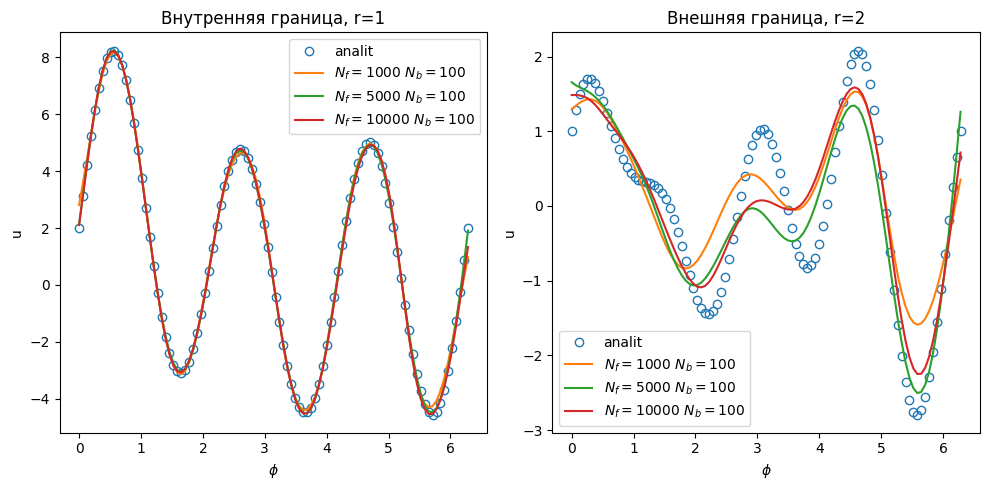

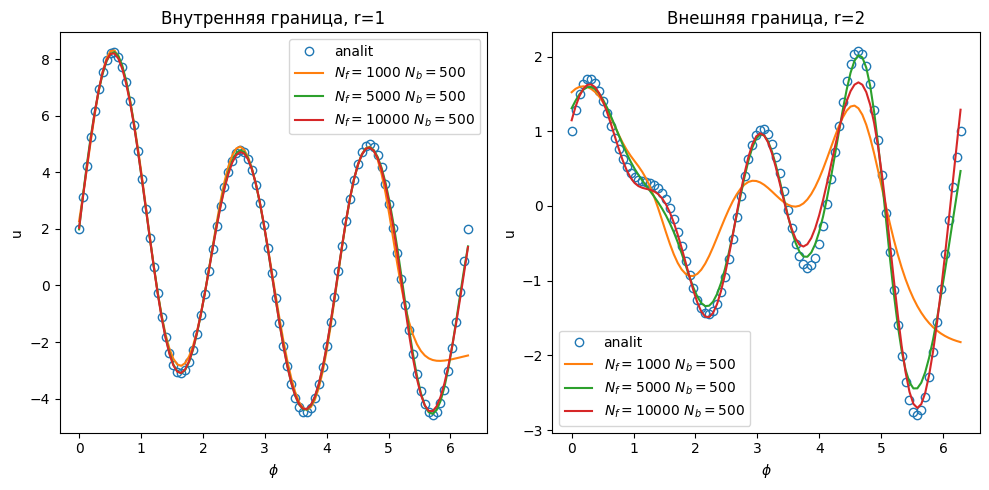

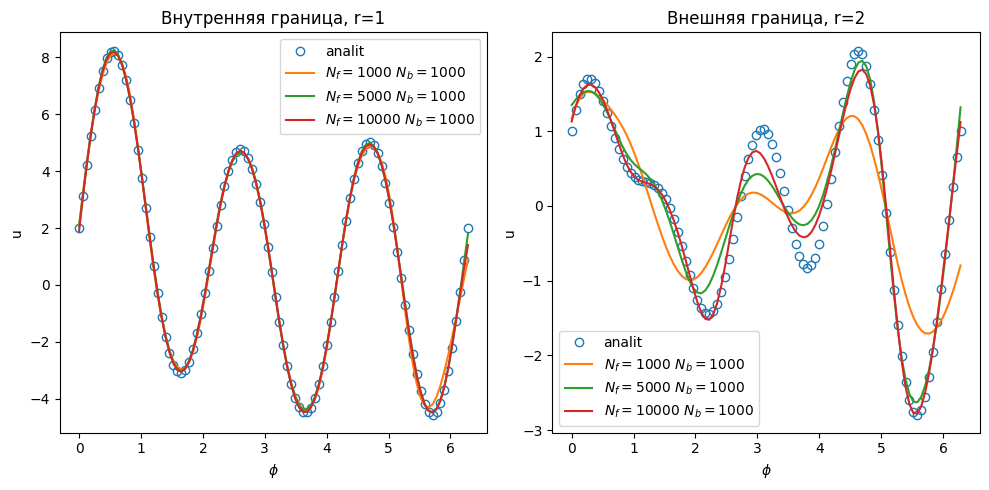

In [160]:
fig1 = plt.figure(figsize=(10,5))
plot_bnd(fig1, old_cases[0:3])
fig1.tight_layout()

fig2 = plt.figure(figsize=(10,5))
plot_bnd(fig2, old_cases[3:6])
fig2.tight_layout()

fig3 = plt.figure(figsize=(10,5))
plot_bnd(fig3, old_cases[6:9])
fig3.tight_layout()

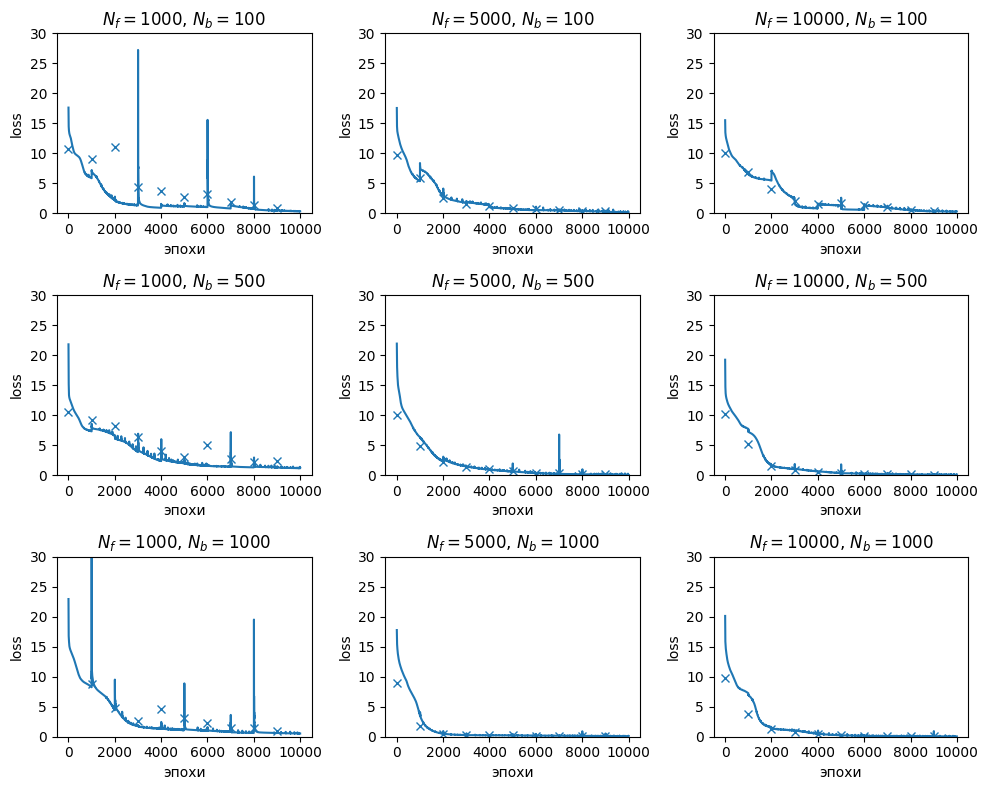

In [175]:
fig, axs = plt.subplots(3, 3, figsize=(10, 8))
for ax, case in zip(axs.flatten(), old_cases):
    Case.plot_loss(case, ax)
    ax.set_ylim(bottom=0, top=30)
fig.tight_layout()

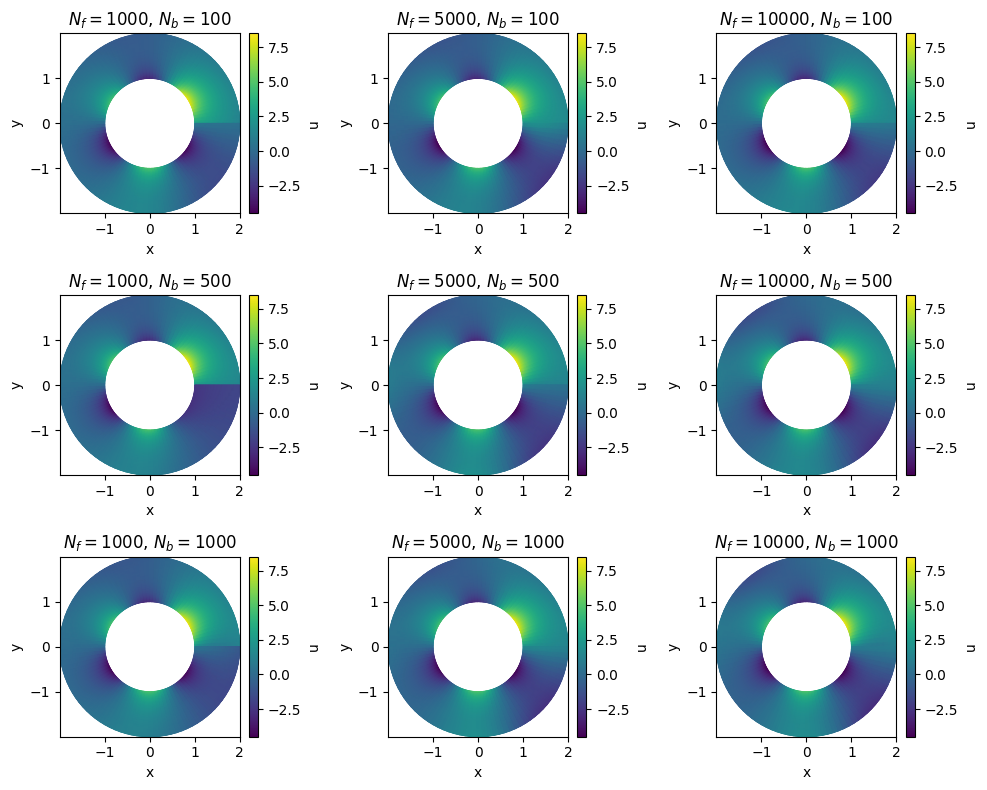

In [188]:
fig, axs = plt.subplots(3, 3, figsize=(10, 8))
for ax, case in zip(axs.flatten(), old_cases):
    plot_colormesh(fig, ax, case.net, title=rf'$N_f={case.N_f}$, $N_b={case.N_i}$')
fig.tight_layout()

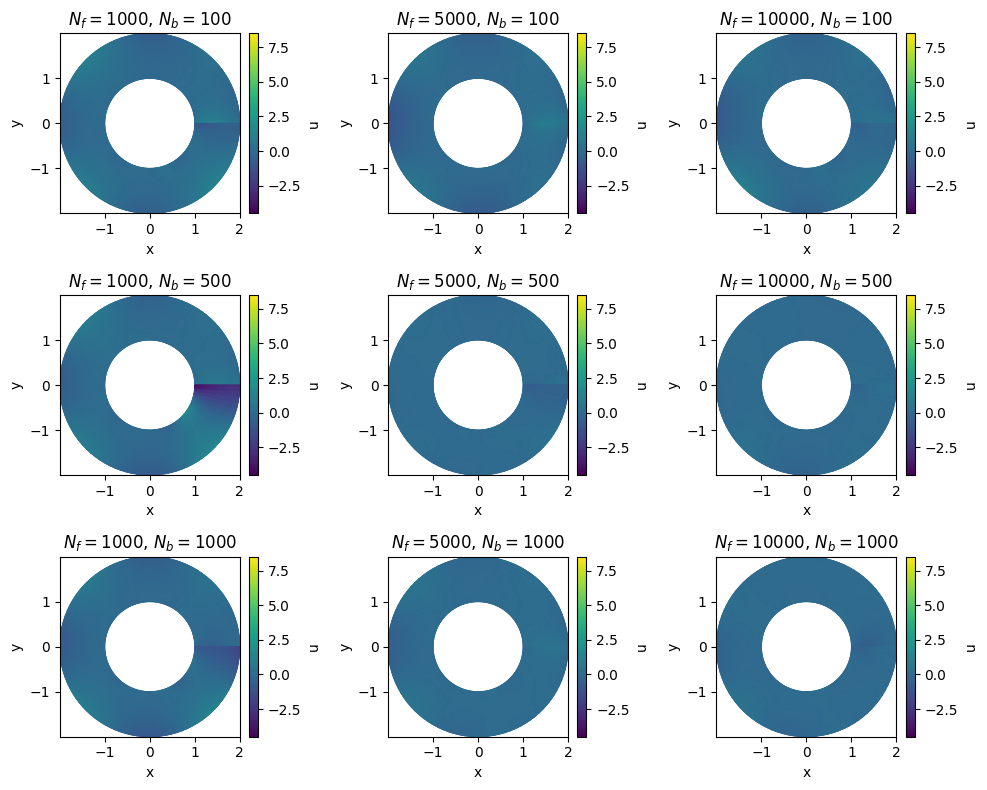

In [189]:
fig, axs = plt.subplots(3, 3, figsize=(10, 8))
for ax, case in zip(axs.flatten(), old_cases):
    plot_colormesh(fig, ax, lambda x: case.net(x).numpy() - solution(x).numpy(), title=rf'$N_f={case.N_f}$, $N_b={case.N_i}$')
fig.tight_layout()

In [ ]:
{a: getattr(old_cases[0], a) for a in dir(old_cases[0]) if not a.startswith('__') and not callable(getattr(old_cases[0], a))}


## -Only Boundary Cond

In [ ]:
def build_pinn(net):
    inputs = [
        tf.keras.layers.Input(shape=2),
        tf.keras.layers.Input(shape=2),
    ]

    class GL(tf.keras.layers.Layer):
        def __init__(self, net):
            super().__init__()
            self.net = net

        def call(self, x):
            with tf.GradientTape(persistent=True) as gg:
                gg.watch(x)
                with tf.GradientTape(persistent=True) as g:
                    g.watch(x)
                    u = net(x)
                u_grad = g.batch_jacobian(u, x)[...,0,:]
                u_r = u_grad[...,0]
                u_f = u_grad[...,1]
            u_jac2 = gg.batch_jacobian(u_grad, x)
            u_r2 = u_jac2[..., 0, 0]
            u_f2 = u_jac2[..., 1, 1]
            return u, u_r2 + 1/x[..., 0]*u_r + 1/x[..., 0]**2*u_f2
    gl = GL(net)

    u_inner, inner = gl(inputs[0])

    u_outer, outer = gl(inputs[1])

    pinn = tf.keras.Model(inputs=inputs, outputs=[u_inner, inner, u_outer, outer])
    pinn.compile('adam', 'mse')
    return pinn


In [ ]:
def train(pinn, train_n, epochs=10000, verbose=0):
    
    rf_inner = np.random.rand(train_n, 2)
    rf_inner[..., 0] = 1
    rf_inner[..., 1] = rf_inner[..., 1] * 2*np.pi

    rf_outer = np.random.rand(train_n, 2)
    rf_outer[..., 0] = 2
    rf_outer[..., 1] = rf_outer[..., 1] * 2*np.pi

    x_train = [rf_inner, rf_outer]
    y_train = [
        inner_cond(rf_inner[..., 1]),
        np.zeros((train_n, 1)),
        outer_cond(rf_outer[..., 1]),
        np.zeros((train_n, 1)),
        ]
    es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, restore_best_weights=True, min_delta=0.001)
    th = TimeHistory()
    sl = ShortLog(100)
    return pinn.fit(x_train, y_train, epochs=epochs, callbacks=[es, th, sl], verbose=verbose), th.times

In [ ]:
res_ob = []
layers = [
    [20, 20, 20],
    [50, 50, 50],
    ]
ns = [1000, 10000, 100000]
for l in layers:
    for n in ns:
        print(n, l)
        res_ob.append(train_case(l, n))

In [ ]:
fig, ax = plt.subplots()
for r in res_b:
    plot_loss(fig, ax, **r)
fig.legend()
fig.tight_layout()

In [ ]:
fig = plt.figure(figsize=(15.,5.))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
n_test = 200
f = np.linspace(0, 2*np.pi, n_test)

analit_in = inner_cond(f)
ax1.plot(f, analit_in, 'o', mfc="none", label='analit')
analit_out = outer_cond(f)
ax2.plot(f, analit_out, 'o', mfc="none", label='analit')

for r in res:
    test(fig, ax1, ax2, r["net"], f'{r["l"]} {r["n"]} ')

ax1.legend()
ax2.legend()


In [ ]:
fig, ax = plt.subplots()
ax.plot(res[0]["loss"])
ax.plot(res[1]["loss"])

## -Boundary Cond

In [ ]:
def build_pinn(net):
    inputs = [
        tf.keras.layers.Input(shape=2),
        tf.keras.layers.Input(shape=2),
        tf.keras.layers.Input(shape=2),
    ]

    class GL(tf.keras.layers.Layer):
        def __init__(self, net):
            super().__init__()
            self.net = net

        def call(self, x):
            with tf.GradientTape(persistent=True) as gg:
                gg.watch(x)
                with tf.GradientTape(persistent=True) as g:
                    g.watch(x)
                    res = net(x)
                u_grad = g.batch_jacobian(res, x)[...,0,:]
                u_r = u_grad[...,0]
                u_f = u_grad[...,1]
            u_jac2 = gg.batch_jacobian(u_grad, x)
            u_r2 = u_jac2[..., 0, 0]
            u_f2 = u_jac2[..., 1, 1]
            return u_r2 + 1/x[..., 0]*u_r + 1/x[..., 0]**2*u_f2
    gl = GL(net)
    lap = gl(inputs[0])

    u_inner = net(inputs[1])
    inner = u_inner

    u_outer = net(inputs[2])
    outer = u_outer

    pinn = tf.keras.Model(inputs=inputs, outputs=[lap, inner, outer])
    pinn.compile('adam', 'mse')
    return pinn


In [ ]:
def train(pinn, train_n, total=100000000, verbose=0, valid_r = 10, valid_f = 10):
    epochs = total // train_n

    rf = np.random.rand(train_n, 2)
    rf[..., 0] = rf[..., 0] + 1
    rf[..., 1] = rf[..., 1] * 2*np.pi

    rf_inner = np.random.rand(train_n, 2)
    rf_inner[..., 0] = 1
    rf_inner[..., 1] = rf_inner[..., 1] * 2*np.pi

    rf_outer = np.random.rand(train_n, 2)
    rf_outer[..., 0] = 2
    rf_outer[..., 1] = rf_outer[..., 1] * 2*np.pi

    x_train = [rf, rf_inner, rf_outer]
    y_train = [
        np.zeros((train_n, 1)),
        inner_cond(rf_inner[..., 1]),
        outer_cond(rf_outer[..., 1]),
    ]

    # r = np.linspace(1., 2., valid_r)
    # f = np.linspace(0, 2*np.pi, valid_f)
    # R, F = np.meshgrid(r, f)

    # x_valid = [
    #     np.stack([R.flatten(), F.flatten()], axis=-1),
    #     np.stack([np.full(F.flatten().shape[0], 1.), F.flatten()], axis=-1),
    #     np.stack([np.full(F.flatten().shape[0], 2.), F.flatten()], axis=-1),
    # ]
    # y_valid = [
    #     solution(x_valid[0]),
    #     inner_cond(x_valid[1]),
    #     outer_cond(x_valid[2]),
    # ]

    th = TimeHistory() 
    callbacks = [
        th,
        tf.keras.callbacks.EarlyStopping(
            monitor='loss', patience=max(100000/train_n, 5), restore_best_weights=True, min_delta=1e-2),
        ShortLog(10, epochs),
    ]
    return pinn.fit(
        x_train, y_train, 
        # validation_data=(x_valid, y_valid),
        validation_split=0.1,
        epochs=epochs, 
        callbacks=callbacks, 
        verbose=verbose
        )


In [ ]:
res_b2 = []
layers = [
    [20, 20, 20],
    # [50, 50, 50],
]
# ns = [1000, 10000, 100000]
ns = [1000, 10000]
for l in layers:
    for n in ns:
        print(f"{l} {n}")
        train_case(res_b2, l, n, total=100000)

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": '3d'})
plot_surface(fig, ax, res_b2[-1]["net"])
plot_surface(fig, ax, solution)

In [ ]:
valid_r, valid_f = 10, 10
r = np.linspace(1., 2., valid_r)
f = np.linspace(0, 2*np.pi, valid_f)
R, F = np.meshgrid(r, f)

x_valid = [
    np.stack([R.flatten(), F.flatten()], axis=-1),
    np.stack([np.full(F.flatten().shape[0], 1.), F.flatten()], axis=-1),
    np.stack([np.full(F.flatten().shape[0], 2.), F.flatten()], axis=-1),
]
y_valid = [
    solution(x_valid[0]),
    inner_cond(x_valid[1]),
    outer_cond(x_valid[2]),
]
y_pred = [
    res_b2[-1]["net"]
]

In [ ]:
fig, ax = plt.subplots()
# plot_colormesh(fig, ax, res_b2[-1]["net"])
# plot_colormesh(fig, ax, solution)
plot_colormesh(fig, ax, lambda x: solution(x).numpy() - tf.cast(res_b2[-1]["net"](x), tf.float64).numpy())

In [ ]:
train_case(res, [20,20,20], 100, total=10000)

In [ ]:
res_b2

In [ ]:
fig, ax = plt.subplots()
for r in res_b2:
    plot_loss(fig, ax, m=2, **r)
ax.legend()
ax.set_xlabel("Время обучения")
ax.set_ylabel("MSE")
# ax.set_yscale('log')
fig.tight_layout()

In [ ]:
for r in res_b:
    r["loss"] = np.array(r["loss"])
    r["t"] = np.array(r["t"])
    if "vlos" in r:
        r["vlos"] = np.array(r["vlos"])
res_b
res_b[0]["pinn"].history.history["loss"]
res_b[0]["loss"]

In [ ]:
for r in res_b1:
    print(f'{r["l"]} {r["n"]:<6} {np.sum(r["t"])}')

In [ ]:
fig = plt.figure(figsize=(10,5))
plot_bnd(fig, res_b[1:3] + res_b[4:6])
fig.tight_layout()

## -Random Sampling

In [ ]:
inputs = tf.keras.layers.Input(shape=(2,))  # r, f
x = inputs
for layer in [16, 8]:
    x = tf.keras.layers.Dense(layer, activation='tanh',
                                kernel_initializer='he_normal')(x)
out = tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x)
net = tf.keras.models.Model(inputs=inputs, outputs=out)

inputs = tf.keras.layers.Input(shape=2)
class GL(tf.keras.layers.Layer):
    def __init__(self, net):
        super().__init__()
        self.net = net

    def call(self, x):
        with tf.GradientTape(persistent=True) as gg:
            gg.watch(x)
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                u = net(x)
            u_grad = g.batch_jacobian(u, x)[...,0,:]
            u_r = u_grad[...,0]
            u_f = u_grad[...,1]
        u_jac2 = gg.batch_jacobian(u_grad, x)
        u_r2 = u_jac2[..., 0, 0]
        u_f2 = u_jac2[..., 1, 1]
        return u, u_r2 + 1/x[..., 0]*u_r + 1/x[..., 0]**2*u_f2

pinn = tf.keras.Model(inputs=inputs, outputs=GL(net)(inputs))
pinn.compile('adam', 'mse')


In [ ]:
for i in range(1):
    train_n = 100000

    rf = np.random.rand(train_n, 2)
    rf[..., 0] = rf[..., 0] + 1
    rf[..., 1] = rf[..., 1] * 2*np.pi

    x_train = rf
    y_train = [
        solution(rf[..., 0], rf[..., 1]),
        np.zeros((train_n, 1)),
        ]
    h = pinn.fit(x_train, y_train, epochs = 100)

In [ ]:
def foo(layers):
    inputs = tf.keras.layers.Input(shape=(2,))  # r, f
    x = inputs
    for layer in layers:
        x = tf.keras.layers.Dense(layer, activation='tanh',
                                    kernel_initializer='he_normal')(x)
    out = tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x)
    net = tf.keras.models.Model(inputs=inputs, outputs=out)

    inputs = tf.keras.layers.Input(shape=2)
    class GL(tf.keras.layers.Layer):
        def __init__(self, net):
            super().__init__()
            self.net = net

        def call(self, x):
            with tf.GradientTape(persistent=True) as gg:
                gg.watch(x)
                with tf.GradientTape(persistent=True) as g:
                    g.watch(x)
                    u = net(x)
                u_grad = g.batch_jacobian(u, x)[...,0,:]
                u_r = u_grad[...,0]
                u_f = u_grad[...,1]
            u_jac2 = gg.batch_jacobian(u_grad, x)
            u_r2 = u_jac2[..., 0, 0]
            u_f2 = u_jac2[..., 1, 1]
            return u, u_r2 + 1/x[..., 0]*u_r + 1/x[..., 0]**2*u_f2

    pinn = tf.keras.Model(inputs=inputs, outputs=GL(net)(inputs))
    pinn.compile('adam', 'mse')

    train_n = 100000

    rf = np.random.rand(train_n, 2)
    rf[..., 0] = rf[..., 0] + 1
    rf[..., 1] = rf[..., 1] * 2*np.pi

    x_train = rf
    y_train = [
        solution(rf[..., 0], rf[..., 1]),
        np.zeros((train_n, 1)),
        ]
    time_log = TimeHistory()
    h = pinn.fit(x_train, y_train, epochs = 100, callbacks=time_log)

    return net, pinn, h.history["loss"], time_log.times, layers

In [ ]:
res=[]
layerss = [
    [80, 40],
    [16, 8],
    [20, 20, 20, 20, 20]
]

for layers in layerss:
    res.append(foo(layers))


In [ ]:
res.append(foo([10, 10, 10, 10]))
res.append(foo([30, 30, 30, 30]))
res.append(foo([40, 40, 40, 40]))
res.append(foo([50, 50, 50, 50]))

In [ ]:
for r in res:
    print(r[-1], np.sum(r[-2]))

In [ ]:
fig, ax = plt.subplots()
ax.plot(h.history["loss"])
ax.set_ylim(bottom=0)

In [ ]:
n_test = 200
f = np.linspace(0, 2*np.pi, n_test)
analit_in = inner_cond(f)
analit_out = outer_cond(f)
pred_in = net.predict(np.stack([np.full((n_test,), 1.), f], axis=-1))
pred_out = net.predict(np.stack([np.full((n_test,), 2.), f], axis=-1))

fig = plt.figure(figsize=(15.,5.))
ax1 = fig.add_subplot(121)
ax1.plot(f, analit_in, 'o', mfc="none", label='analit')
ax1.plot(f, pred_in, label='predict')
ax1.legend()
ax2 = fig.add_subplot(122)
ax2.plot(f, analit_out, 'o', mfc="none", label='analit')
ax2.plot(f, pred_out, label='predict')
ax2.legend()

# Retrieve Parameter

## -Simple Test

In [ ]:
inputs = tf.keras.layers.Input(1)
v = tf.keras.layers.Dense(1, use_bias=False)
out = v(inputs)
m = tf.keras.models.Model(inputs=inputs, outputs=out)

m.compile('adam', 'mse')

In [ ]:

x = np.linspace(0, 10, 20)
y = x*3
m.fit(x=x, y=y, epochs=1, verbose=1)

In [ ]:
v.get_weights()[0][0,0]

## -Difur Test

In [ ]:
def solution(x):
    return tf.exp(2*x) + tf.exp(x)

In [ ]:
x = tf.constant([[1.],[2.],[3.]])

with tf.GradientTape(persistent=True) as gg:
    gg.watch(x)
    with tf.GradientTape(persistent=True) as g:
        g.watch(x)
        u = solution(x)
    u_x = g.batch_jacobian(u, x)[..., 0, :]
u_xx = gg.batch_jacobian(u_x, x)[..., 0, :]

print(u)
print(u_x)
print(u_xx)
print(u_xx - 3*u_x + 2*u)

In [ ]:
for l in net.layers:
    l.trainable = False

In [ ]:
class GL(tf.keras.layers.Layer):
    def __init__(self, net):
        super().__init__()
        self.net = net

    def call(self, x):
        with tf.GradientTape(persistent=True) as gg:
            gg.watch(x)
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                u = self.net(x)
            u_x = g.batch_jacobian(u, x)[..., 0, :]
        u_xx = gg.batch_jacobian(u_x, x)[..., 0, :]
        return u, u_x, u_xx

inputs = tf.keras.layers.Input(1)
u, u_x, u_xx = GL(solution)(inputs)
a = tf.keras.layers.Dense(1, use_bias=False)
b = tf.keras.layers.Dense(1, use_bias=False)
r = u_xx + a(u_x) + b(u)
# r = u_xx - 3*u_x + 2*u
pinn = tf.keras.models.Model(inputs=inputs, outputs=r)
pinn.compile('adam', 'mse')

In [ ]:
x = np.linspace(0, 1, 10000)
u = solution(x)

pinn.fit(x=x, y=np.zeros_like(u), verbose=1, epochs=1000, callbacks=[es])

In [ ]:
print(f"{a.weights[0].numpy()[0,0]:.2f} {b.weights[0].numpy()[0,0]:.2f}")

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, u, label='analit')
u_p = net.predict(x)
ax.plot(x, u_p, label='pred')
ax.set_ylim(bottom=0,top=11)
fig.legend()

## -Retrieve Constant

In [ ]:
def build_net(layers, activation, dim, **kwargs):
    inputs = tf.keras.layers.Input(shape=(1+dim,))
    x = inputs
    for layer in layers:
        x = tf.keras.layers.Dense(layer, activation=activation,
                                    kernel_initializer='he_normal')(x)

    outs = tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x)
    return tf.keras.models.Model(inputs=inputs, outputs=outs)

class TestL(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.a = tf.Variable(0., trainable=True)
        self.b = tf.Variable(0., trainable=True)

    def call(self, x):
        return self.a*x+self.b

inputs = tf.keras.layers.Input(shape=(1,))
out = TestL()(inputs)
nett = tf.keras.Model(inputs=inputs, outputs=out)
nett.compile('adam', 'mse')
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
x = np.linspace(0, 100, 100000)
y = 5*x-8

nett.fit(x=x, y=y, epochs=1000, callbacks=[es])
print(nett.layers[0])

In [ ]:
print(nett.layers[1].a)

## -Retrieve EK Parameters

In [ ]:
def build_net(layers, activation, dim, **kwargs):
    inputs = tf.keras.layers.Input(shape=(1+dim,))
    x = inputs
    for layer in layers:
        x = tf.keras.layers.Dense(layer, activation=activation,
                                    kernel_initializer='he_normal')(x)

    outs = {
        "c": tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x),
        "v": tf.keras.layers.Dense(dim, kernel_initializer='he_normal')(x),
        "Fi": tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x),
    }
    return tf.keras.models.Model(inputs=inputs, outputs=outs)


In [ ]:
net = build_net([20,20,20,20], 'tanh', 3)
net.compile('adam', 'mse')

In [ ]:
def norm(x):
    return x/max(abs(x.max()), abs(x.min()))

In [ ]:
pos = np.load("ek_sim_data/position.npy")
pos_l = pos.reshape(-1, 4)
pos_ln = np.concatenate([norm(pos_l[:, 0:1]), norm(pos_l[:, 1:4])], axis=-1)

c_r = np.load("ek_sim_data/density.npy")
c_l = c_r.reshape(-1, 1)
c_ln = norm(c_l)

v_r = np.load("ek_sim_data/velocity.npy")
v_l = v_r.reshape(-1, 3)
v_ln = norm(v_l)

Fi_r = np.load("ek_sim_data/potential.npy")
Fi_l = Fi_r.reshape(-1, 1)
Fi_ln = norm(Fi_l)


In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
net.fit(x=pos_ln, y={"c": c_ln, "v": v_ln, "Fi": Fi_ln}, epochs=1000, callbacks=[es])


In [ ]:
fig, ax = plt.subplots()
pos_r = np.concatenate([norm(pos[..., 0:1]), norm(pos[..., 1:4])], axis=-1)
x=pos_r[-1,:,-1,-1,1]
y=norm(np.load("ek_sim_data/density.npy"))[-1,:,-1,-1]
ax.plot(x, y)
ax.plot(x, net.predict(pos_r[-1, :, -1, -1, :])["c"])


In [ ]:
fig, ax = plt.subplots()
pos_r = np.concatenate([norm(pos[..., 0:1]), norm(pos[..., 1:4])], axis=-1)
x = pos_r[-1, :, -1, -1, 1]
y = c_r[-1, :, -1, -1]

xx = tf.constant(pos_r[-1, :, -1, -1, :])
with tf.GradientTape(persistent=True) as gt:
    gt.watch(xx)
    v = net(xx)["v"]
v_jac = gt.batch_jacobian(v, xx)
v_grd = v_jac[..., 1:4]
v_div = tf.linalg.trace(v_grd)

ax.plot(x, v_div)


In [ ]:
class ConstLayer(tf.keras.layers.Layer):
    def __init__(self, model, **kwargs):
        self.model = model
        super().__init__()
        # super().__init__(**kwargs)
        self.D = tf.Variable(0.006075, trainable=True)
        self.xi = tf.Variable(1., trainable=True)
        self.z = tf.Variable(-1., trainable=True)
        self.e = tf.Variable(1., trainable=True)
        self.ro = tf.Variable(26.15, trainable=True)
        self.kT = tf.Variable(1., trainable=True)
        self.lB = tf.Variable(0.7095, trainable=True)
        self.nu = tf.Variable(1., trainable=True)
        self.p_grd = tf.Variable([0., 0.1, 0.], trainable=True)

    def call(self, x):
        tdim = slice(0, 1)
        sdim = slice(1, 4)
        with tf.GradientTape(persistent=True) as gg:
            gg.watch(x)
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                r = self.model(x)
                c, v, Fi = r["c"], r["v"], r["Fi"]

            c_jac = g.batch_jacobian(c, x)[..., 0, :]
            c_t = c_jac[..., tdim]
            c_grd = c_jac[..., sdim]

            v_jac = g.batch_jacobian(v, x)
            v_t = v_jac[..., tdim][..., 0]
            v_grd = v_jac[..., sdim]
            v_div = tf.linalg.trace(v_grd)[:, None]
            v_adv = tf.reduce_sum(v[:, None]*v_grd, axis=-1)

            Fi_jac = g.batch_jacobian(Fi, x)[..., 0, :]
            Fi_grd = Fi_jac[..., sdim]

            j = -self.D*c_grd - self.xi*self.z*self.e*c*Fi_grd + c*v

        v_grd2 = gg.batch_jacobian(v_grd, x)[..., sdim]
        v_lap = tf.linalg.trace(v_grd2)

        Fi_grd_jac = gg.batch_jacobian(Fi_grd, x)
        Fi_lap = tf.linalg.trace(Fi_grd_jac[..., sdim])[:, None]

        j_jac = gg.batch_jacobian(j, x)
        j_div = tf.linalg.trace(j_jac[..., sdim])[:, None]

        eq_1 = c_t + j_div
        eq_2 = Fi_lap + self.lB*self.kT*(self.z*c)
        eq_3 = self.ro*(v_t + v_adv*v) + self.p_grd + self.nu * \
            v_lap - self.kT*c_grd + self.z*self.e*c*Fi_grd

        return eq_1, eq_2, eq_3


In [ ]:
for l in net.layers:
    l.trainable=False
inputs =tf.keras.Input(4)
cl = ConstLayer(net)
out = cl(inputs)
pinn = tf.keras.Model(inputs=inputs, outputs=out)
pinn.compile('adam', 'mse')


In [ ]:
pinn.fit(x=pos_ln, y=[np.zeros(pos_ln.shape[0])]*len(pinn.outputs), epochs=1000, callbacks=[es])


In [ ]:
pinn.layers[1].z

In [ ]:
x = tf.constant(pos_ln)

tdim = slice(0, 1)
sdim = slice(1, 4)
with tf.GradientTape(persistent=True) as gg:
    gg.watch(x)
    with tf.GradientTape(persistent=True) as g:
        g.watch(x)
        r = net(x)
        c, v, Fi = r["c"], r["v"], r["Fi"]

    c_jac = g.batch_jacobian(c, x)[..., 0, :]
    c_t = c_jac[..., tdim]
    c_grd = c_jac[..., sdim]

    v_jac = g.batch_jacobian(v, x)
    v_t = v_jac[..., tdim][..., 0]
    v_grd = v_jac[..., sdim]
    v_div = tf.linalg.trace(v_grd)[:, None]
    v_adv = tf.reduce_sum(v[:, None]*v_grd, axis=-1)

    Fi_jac = g.batch_jacobian(Fi, x)[..., 0, :]
    Fi_grd = Fi_jac[..., sdim]

v_grd2 = gg.batch_jacobian(v_grd, x)[..., sdim]
v_lap = tf.linalg.trace(v_grd2)

Fi_grd_jac = gg.batch_jacobian(Fi_grd, x)
Fi_lap = tf.linalg.trace(Fi_grd_jac[..., sdim])[:, None]

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection":'3d'})
pos_n = norm(pos)
ax.plot_surface(pos[0,0,:,:,2], pos[0,0,:,:,3], Fi.numpy().reshape(Fi_r.shape)[-1, 0, :, :], label="p")
ax.plot_surface(pos[0,0,:,:,2], pos[0,0,:,:,3], Fi_ln.reshape(Fi_r.shape)[-1, 0, :, :], label="a")
ax.set_zlim(bottom=-1, top=1)
fig.legend()

In [ ]:
fig, ax = plt.subplots()
ax.plot(Fi.numpy().reshape(Fi_r.shape)[0, :, 0,0])
ax.plot(Fi_r[0, :, 0,0])

# Test

In [ ]:
input = tf.keras.Input(1)
x = input
act = 'tanh'
act = 'relu'
x = tf.keras.layers.Dense(5, act)(x)
x = tf.keras.layers.Dense(5, act)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.models.Model(inputs=input, outputs=output)

x = tf.constant([[1],[2],[3]], dtype=tf.float32)
with tf.GradientTape(persistent=True) as g:
    g.watch(x)
    with tf.GradientTape(persistent=True) as gg:
        gg.watch(x)
        r = model(x)
    d1 = gg.batch_jacobian(r, x)
d2 = g.batch_jacobian(d1, x)
print(d1.numpy(), d2.numpy(), sep='\n')